# Real-Time Cryptocurrency Volatility Detection - Exploratory Data Analysis

**Milestone 2: Feature Engineering & EDA**

This notebook explores the engineered features from the Coinbase WebSocket feed to:
1. Understand data distributions across products
2. Analyze volatility patterns and temporal dynamics
3. Set a threshold for 60-second volatility spike detection
4. Validate feature quality and completeness

RESOURCE: Evidently | https://docs.evidentlyai.com/introduction

In [71]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import warnings

from datetime import datetime
from evidently import Report
from evidently.metrics import *
from evidently.presets import *
from pathlib import Path

# Styling
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Add directory paths.
cwd = Path.cwd()
parent_dir = cwd.parent

# Remove warning when there is no variance.
warnings.filterwarnings('ignore', message='invalid value encountered in divide')

# Magic!
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Assembly of Features Data

In [72]:
# NOTE: One of the files does not include USDT data. It was only captured as a possible control.
# Was worried there might be an actual market catastrophe during this collection window.
# This means fewer observations, but this should not be an issue. It is a stablecoin.

# Find all feature parquet files.
feature_files = list(Path(f'{parent_dir}/data/processed/eda').glob('*.parquet'))

# Load and combine.
dfs = [pd.read_parquet(f) for f in feature_files]
combined = pd.concat(dfs, ignore_index=True)

# Sort by time and remove any duplicates.
combined = combined.sort_values('timestamp').drop_duplicates()

# Save combined file.
combined.to_parquet(f'{cwd}/features_combined.parquet', index=False)

print(f'Combined {len(feature_files)} files')
print(f'Total observations: {len(combined):,}') # Observations correspond to 'ticker' type messages.
print(f'Products: {combined['product_id'].unique()}')
print(f'Time range: {combined['timestamp'].min()} to {combined['timestamp'].max()}') # This is the total span, but it is not continuous.

Combined 5 files
Total observations: 901,249
Products: ['ETH-USD' 'SOL-USD' 'BTC-USD' 'USDT-USD']
Time range: 2025-11-16 02:47:14.009841+00:00 to 2025-11-21 22:52:57.452668+00:00


In [73]:
# Load processed features.
features_path = Path(f'{cwd}/features_combined.parquet')

if not features_path.exists():
    print(f'Feature file not found at {features_path}')
    print('Please run featurizer or replay script first')
else:
    df = pd.read_parquet(features_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert once here.
    print(f'Loaded {len(df):,} feature observations')
    print(f'Time range: {df["timestamp"].min()} to {df["timestamp"].max()}')
    print(f'Products: {df["product_id"].unique()}')

# USDT is not one of our target variables for the model.
target_products = ['BTC-USD', 'ETH-USD', 'SOL-USD']

Loaded 901,249 feature observations
Time range: 2025-11-16 02:47:14.009841+00:00 to 2025-11-21 22:52:57.452668+00:00
Products: ['ETH-USD' 'SOL-USD' 'BTC-USD' 'USDT-USD']


In [74]:
# Basic data overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901249 entries, 0 to 901248
Columns: 120 entries, product_id to target_horizon_sec
dtypes: datetime64[ns, UTC](1), float64(108), int64(9), object(2)
memory usage: 825.1+ MB


In [75]:
# First few rows
df.head()

,product_id,timestamp,feature_timestamp,hour_of_day,minute_of_hour,hour_sin,hour_cos,day_of_week,w30_price_mean,w30_price_std,...,w900_n_observations,w900_ob_bid_depth_L1_mean,w900_ob_ask_depth_L1_mean,w900_ob_depth_imbalance_L1,w900_ob_microprice_mean,w900_ob_microprice_std,target_volatility,target_spike,target_threshold,target_horizon_sec
0,ETH-USD,2025-11-16 02:47:14.009841+00:00,2025-11-23T04:32:50.684866+00:00,2,47,0.5,0.866025,6,3186.370000,0.000000e+00,...,2,2.110003,0.676512,0.514439,3186.367572,0.0,0.000008,0,0.000013,60
1,ETH-USD,2025-11-16 02:47:14.010030+00:00,2025-11-23T04:32:50.686281+00:00,2,47,0.5,0.866025,6,3186.397500,4.763140e-02,...,4,2.110003,0.676512,0.514439,3186.367572,0.0,0.000008,0,0.000013,60
2,ETH-USD,2025-11-16 02:47:14.010030+00:00,2025-11-23T04:32:50.685580+00:00,2,47,0.5,0.866025,6,3186.370000,4.547474e-13,...,3,2.110003,0.676512,0.514439,3186.367572,0.0,0.000008,0,0.000013,60
3,ETH-USD,2025-11-16 02:47:14.010111+00:00,2025-11-23T04:32:50.688870+00:00,2,47,0.5,0.866025,6,3186.414000,5.388877e-02,...,5,2.110003,0.676512,0.514439,3186.367572,0.0,0.000008,0,0.000013,60
4,ETH-USD,2025-11-16 02:47:14.010195+00:00,2025-11-23T04:32:50.691361+00:00,2,47,0.5,0.866025,6,3186.428333,5.871305e-02,...,6,2.110003,0.676512,0.514439,3186.367572,0.0,0.000007,0,0.000013,60


## Data Quality Assessment

In [76]:
# Missing value analysis
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)

missing_summary = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct
})

print('Columns with missing values:')
print(missing_summary[missing_summary['missing_count'] > 0].sort_values('missing_pct', ascending=False))

Columns with missing values:
                           missing_count  missing_pct
w30_return_skew                      379     0.042053
w30_return_kurt                      379     0.042053
w30_price_mean                        79     0.008766
w30_trade_volume                      79     0.008766
w30_ob_microprice_std                 79     0.008766
w30_ob_microprice_mean                79     0.008766
w30_ob_depth_imbalance_L1             79     0.008766
w30_ob_ask_depth_L1_mean              79     0.008766
w30_ob_bid_depth_L1_mean              79     0.008766
w30_n_observations                    79     0.008766
w30_tick_rate                         79     0.008766
w30_tick_interval_std                 79     0.008766
w30_avg_tick_interval                 79     0.008766
w30_trade_imbalance                   79     0.008766
w30_avg_trade_size                    79     0.008766
w30_trade_count                       79     0.008766
w30_price_std                         79     0.008766

I will be honest, I have never worked with streamed data like this before, but I have worked with a lot of datasets, and that missing_pct inspires tears of joy.

In [77]:
print(df.info())
df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901249 entries, 0 to 901248
Columns: 120 entries, product_id to target_horizon_sec
dtypes: datetime64[ns, UTC](1), float64(108), int64(9), object(2)
memory usage: 825.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 900784 entries, 0 to 901246
Columns: 120 entries, product_id to target_horizon_sec
dtypes: datetime64[ns, UTC](1), float64(108), int64(9), object(2)
memory usage: 831.6+ MB
None


Observations per product:
product_id
BTC-USD     355313
SOL-USD     278477
ETH-USD     257133
USDT-USD      9861
Name: count, dtype: int64


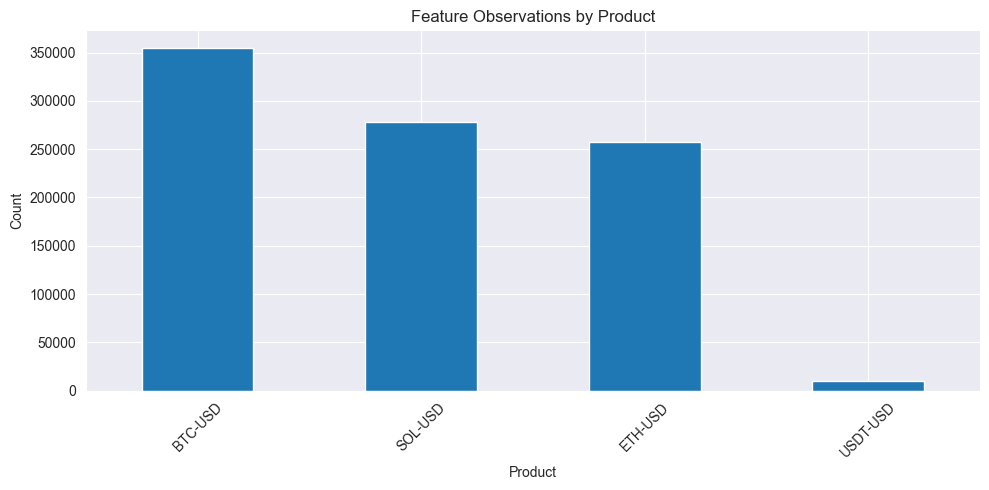

In [78]:
# Observations per product
product_counts = df['product_id'].value_counts()
print('Observations per product:')
print(product_counts)

# Visualize.
plt.figure(figsize=(10, 5))
product_counts.plot(kind='bar')
plt.title('Feature Observations by Product')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

I am slightly surprised that there is more SOL activity than ETH, but I am not really a crypto expert. I did read it was in a bit of a crash, but not sure if that is an earned level of surprise. This otherwise seems quite reasonable. While USDT might be the most liquid stabecoin, it is a stablecoin, so not a lot of trade movement. SOL is a coin I chose that would present some higher volatility while not being an actual memecoin. ETH was chosen to reflect what I expected to be a medium level of volatility, and BTC relatively more stable, even during a period of overall decline.

These data comprise 5 different ingestions chosen during specific market windows. (Crypto trades 24/7 and globally, but market hours seem like a potentially relevant influencing factor.) These represent data from US, Europe, and Asia Monday morning market open windows; Saturday offpeak; Friday US after hours. If I were to continue to work on this, I would like to have data from other windows as well, particularly midweek. I excluded previous collections from that time after modifying my ingestion script, and would like to have a more representative sample.

In [79]:
# Identify sessions by time gaps > 1 hour
df_sorted = df.sort_values('timestamp').copy()
df_sorted['time_gap'] = df_sorted['timestamp'].diff() > pd.Timedelta(hours=1)
df_sorted['session'] = df_sorted['time_gap'].cumsum()

# Calculate total collection time across all sessions
total_duration = pd.Timedelta(0)

print('Collection duration by session:')
print()

for session in df_sorted['session'].unique():
    session_df = df_sorted[df_sorted['session'] == session]
    duration = session_df['timestamp'].max() - session_df['timestamp'].min()
    total_duration += duration
    
    start = session_df['timestamp'].min()
    end = session_df['timestamp'].max()
    obs_count = len(session_df)
    
    print(f'Session {session + 1}:') # Get rid of 0 index.
    print(f'  {start.strftime("%Y-%m-%d %H:%M")} to {end.strftime("%H:%M")}')
    print(f'  Duration: {duration}')
    print(f'  Observations: {obs_count:,}')
    print()

df = df_sorted.copy()

print(f'Total collection time: {total_duration}')
print(f'Total hours: {total_duration.total_seconds() / 3600:.1f}')

Collection duration by session:

Session 1:
  2025-11-16 02:47 to 04:47
  Duration: 0 days 01:59:59.636814
  Observations: 197,919

Session 2:
  2025-11-17 02:26 to 03:25
  Duration: 0 days 00:59:58.299297
  Observations: 56,829

Session 3:
  2025-11-17 07:55 to 09:55
  Duration: 0 days 01:59:56.270578
  Observations: 80,758

Session 4:
  2025-11-17 14:32 to 15:22
  Duration: 0 days 00:49:59.612163
  Observations: 132,526

Session 5:
  2025-11-21 18:52 to 22:52
  Duration: 0 days 03:59:59.490137
  Observations: 432,752

Total collection time: 0 days 09:49:53.308989
Total hours: 9.8


## Feature Distributions

Examining the distribution of key features across products.

In [80]:
# Get feature columns.
feature_cols = [col for col in df.columns if col.startswith('w')]
print(f'Found {len(feature_cols)} feature columns')
print('Feature columns:', feature_cols[:10], '...')

Found 108 feature columns
Feature columns: ['w30_price_mean', 'w30_price_std', 'w30_price_min', 'w30_price_max', 'w30_price_range', 'w30_price_momentum', 'w30_price_trend', 'w30_return_mean', 'w30_return_std', 'w30_return_skew'] ...


I collect a suite of features over 4 different look-back windows: 30, 60, 300, and 900 seconds. I had also originally included 15 seconds, but it did not seem to contribute anything, and I removed it.

In [81]:
# Summary statistics for key features
key_features = ['w60_price_mean', 'w60_return_std', 'w60_spread_mean', 'w60_trade_count']

summary_stats = df[key_features + ['product_id']].groupby('product_id').describe()
print('Summary statistics by product:')
print(summary_stats)

Summary statistics by product:
           w60_price_mean                                           \
                    count          mean          std           min   
product_id                                                           
BTC-USD          355313.0  88921.492862  5313.719210  83419.271446   
ETH-USD          257133.0   2953.953361   212.333084   2708.282076   
SOL-USD          278477.0    136.824418     5.929371    125.827424   
USDT-USD           9861.0      0.999348     0.000096      0.999029   

                                                                    \
                     25%           50%           75%           max   
product_id                                                           
BTC-USD     84482.946081  84928.429076  95214.534312  95927.378226   
ETH-USD      2747.541818   2780.357280   3181.210022   3210.963323   
SOL-USD       129.029869    140.472579    141.079988    142.402372   
USDT-USD        0.999293      0.999350      0.999424      

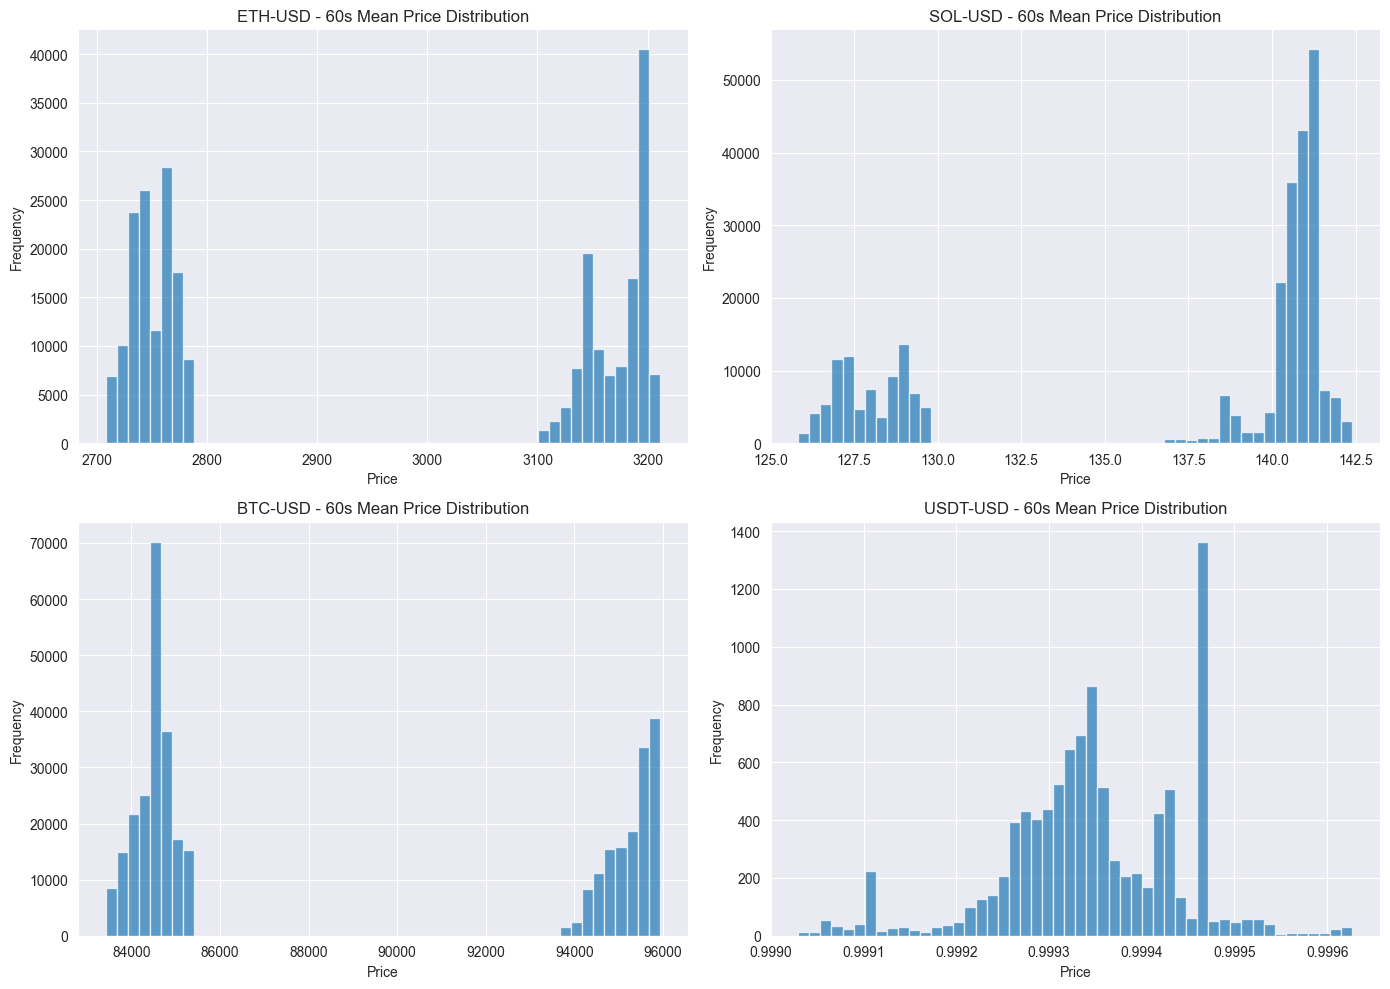

In [82]:
# Distribution plots for 60s price features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, product in enumerate(df['product_id'].unique()[:4]):
    ax = axes[idx // 2, idx % 2] # Map to grid.
    product_df = df[df['product_id'] == product]
    
    if 'w60_price_mean' in product_df.columns:
        product_df['w60_price_mean'].hist(bins=50, ax=ax, alpha=0.7)
        ax.set_title(f'{product} - 60s Mean Price Distribution')
        ax.set_xlabel('Price')
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

I collected data at  multiple timepoints on different days, so the split distributions look a bit strange since the drop or gain in price that occurred in between collections is not reflected. The stablecoin looks closer to a normal distirbution, which is what I would expect, barring a market catastrophe of some kind.

## Volatility Analysis

Analyzing the 60-second rolling return volatility, which should be a key metric for spike detection.

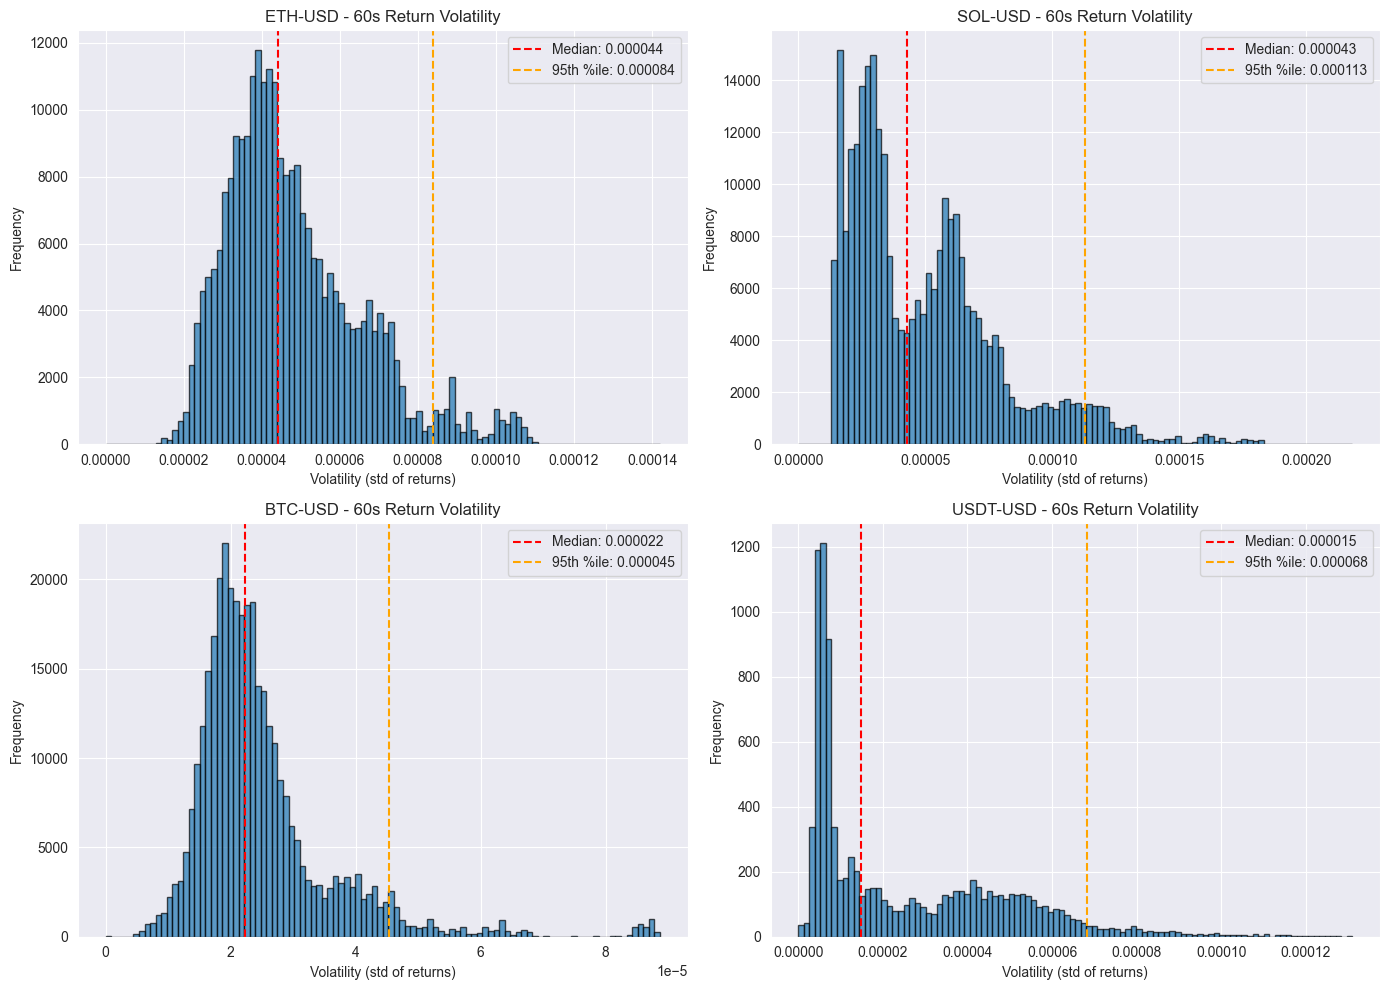

In [83]:
# Volatility distributions by product
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, product in enumerate(df['product_id'].unique()[:4]):
    ax = axes[idx // 2, idx % 2] # Map to grid.
    product_df = df[df['product_id'] == product].copy()
    
    if 'w60_return_std' in product_df.columns:
        volatility = product_df['w60_return_std'].dropna() # Not that there are that many!
        
        volatility.hist(bins=100, ax=ax, alpha=0.7, edgecolor='black')
        # Adding verticals to help with narror distributions. Some long tails here. Which I suppose is the point.
        ax.axvline(volatility.median(), color='red', linestyle='--', label=f'Median: {volatility.median():.6f}')
        # Showing 95th percentile even though will likely need to go lower because data are so imbalanced.
        ax.axvline(volatility.quantile(0.95), color='orange', linestyle='--', label=f'95th %ile: {volatility.quantile(0.95):.6f}') # I hate %ile as an abbreviation, but it looks better.
        
        ax.set_title(f'{product} - 60s Return Volatility')
        ax.set_xlabel('Volatility (std of returns)')
        ax.set_ylabel('Frequency')
        ax.legend()

plt.tight_layout()
plt.show()

In [84]:
# Volatility statistics across all products
print('Volatility statistics (w60_return_std):')
print()

for product in df['product_id'].unique():
    product_df = df[df['product_id'] == product].copy()
    
    if 'w60_return_std' in product_df.columns:
        vol = product_df['w60_return_std'].dropna()
        
        print(f'{product}:')
        print(f'  Mean: {vol.mean():.6f}')
        print(f'  Median: {vol.median():.6f}')
        print(f'  Std: {vol.std():.6f}')
        print(f'  Min: {vol.min():.6f}')
        print(f'  Max: {vol.max():.6f}')
        print(f'  90th percentile: {vol.quantile(0.90):.6f}')
        print(f'  95th percentile: {vol.quantile(0.95):.6f}')
        print(f'  99th percentile: {vol.quantile(0.99):.6f}')
        print()

Volatility statistics (w60_return_std):

ETH-USD:
  Mean: 0.000048
  Median: 0.000044
  Std: 0.000018
  Min: 0.000000
  Max: 0.000142
  90th percentile: 0.000072
  95th percentile: 0.000084
  99th percentile: 0.000104

SOL-USD:
  Mean: 0.000050
  Median: 0.000043
  Std: 0.000030
  Min: 0.000000
  Max: 0.000218
  90th percentile: 0.000093
  95th percentile: 0.000113
  99th percentile: 0.000148

BTC-USD:
  Mean: 0.000025
  Median: 0.000022
  Std: 0.000011
  Min: 0.000000
  Max: 0.000089
  90th percentile: 0.000039
  95th percentile: 0.000045
  99th percentile: 0.000067

USDT-USD:
  Mean: 0.000026
  Median: 0.000015
  Std: 0.000023
  Min: 0.000000
  Max: 0.000131
  90th percentile: 0.000058
  95th percentile: 0.000068
  99th percentile: 0.000096



## Feature Correlations

In [85]:
# Correlation of each feature with target
feature_cols = [col for col in df.columns if col.startswith('w')]
time_features = ['hour_sin', 'hour_cos', 'day_of_week']
feature_cols.extend([f for f in time_features if f in df.columns])
correlations = df[feature_cols].corrwith(df['target_spike']).abs().sort_values(ascending=False)

top_50_features = correlations.head(50).index.tolist()


print('Top 50 Features by Correlation with Target:')
print(top_50_features)
print('')
print(correlations.head(30))

Top 50 Features by Correlation with Target:
['w60_spread_std', 'w30_price_momentum', 'w30_spread_std', 'w60_price_momentum', 'w60_return_kurt', 'w60_spread_mean', 'w60_price_trend', 'w60_return_std', 'w60_volatility_lag1', 'w30_spread_mean', 'w30_return_mean', 'w30_volatility_lag1', 'w30_return_std', 'w60_return_mean', 'w900_return_kurt', 'w60_price_std', 'w30_price_trend', 'w300_spread_std', 'w300_return_kurt', 'w30_price_std', 'w60_price_range', 'w900_spread_std', 'hour_cos', 'w900_price_momentum', 'w30_return_kurt', 'w30_price_range', 'w300_price_momentum', 'w900_ob_microprice_std', 'w900_trade_imbalance', 'w300_ob_microprice_std', 'hour_sin', 'w30_tick_interval_std', 'w300_ob_depth_imbalance_L1', 'w300_spread_mean', 'w60_trade_volume', 'w60_ob_microprice_std', 'w900_return_skew', 'w300_return_std', 'w300_volatility_lag1', 'w30_trade_volume', 'w300_tick_interval_std', 'w60_tick_interval_std', 'w900_price_std', 'w900_trade_volume', 'w900_spread_mean', 'w900_ob_depth_imbalance_L1', 'w

I wasn't sure which features would really be relevant here. I did a lot of research on crypto markets (which has had some unfortunate consequences on the algorithms governing what advertisements to serve me) and thre them all at the wall to see what would stick. I intitially had included a 15 second lookback as well, but it was virtually indistinguishable from the 30-second look back in influence, so I removed it. The 5-minute and 15-minute windows' correlation is interesting. I am collecting my order book dfata from the l2-batch channel. I wasn't sure if the live l2 channel was feasible for me to actually process. Because the data all have timestamps, I would assume the batched info is not an issue, but it is possible the results would differ slightly if I were collecting that all in real time.

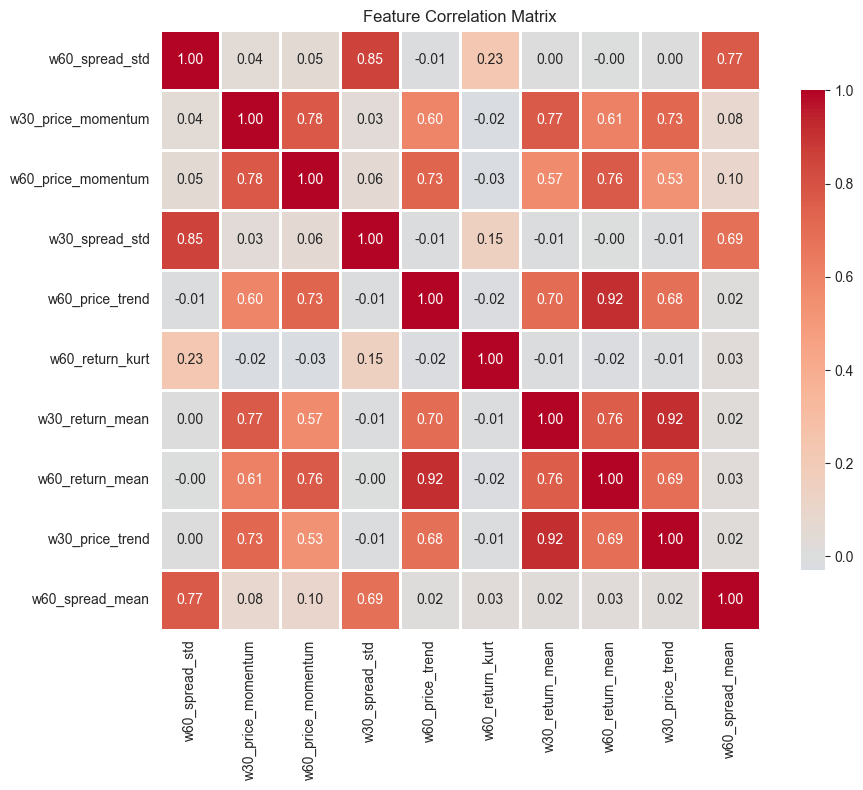

In [86]:
# Correlation matrix for key features
correlation_features = [
    'w60_spread_std', 'w30_price_momentum', 'w60_price_momentum', 'w30_spread_std',
    'w60_price_trend', 'w60_return_kurt', 'w30_return_mean', 'w60_return_mean',
    'w30_price_trend', 'w60_spread_mean'
]

# # Filter to features that still exist after my updates.
# correlation_features = [f for f in correlation_features if f in df.columns]

if correlation_features:
    corr_matrix = df[correlation_features].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

## Spike Threshold Selection

Percentile analysis to set the threshold τ for volatility spike detection

In [87]:
target_df = df[df['product_id'].isin(target_products)] # Exclude USDT.

tar_volatility = target_df['w60_return_std'].dropna()

print(f'Total volatility observations: {len(tar_volatility):,}')
print(f'Mean: {tar_volatility.mean():.6f}')
print(f'Median: {tar_volatility.median():.6f}')
print(f'Std: {tar_volatility.std():.6f}')

Total volatility observations: 890,923
Mean: 0.000039
Median: 0.000032
Std: 0.000024


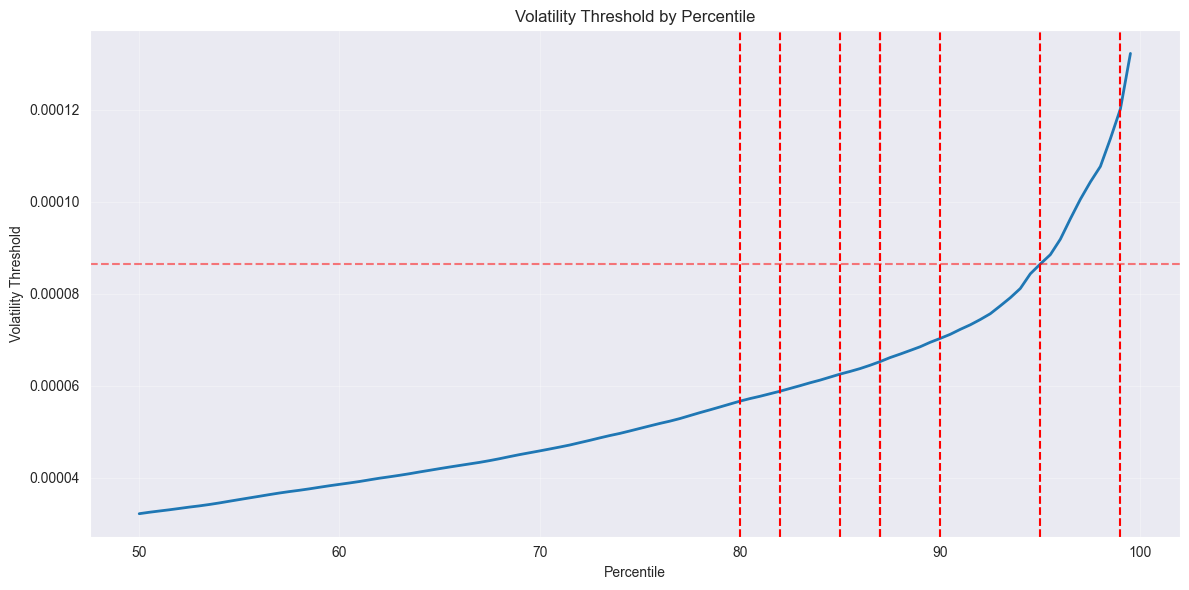

In [88]:
# Percentile plot for threshold selection
percentiles = np.arange(50, 100, 0.5)
threshold_values = [tar_volatility.quantile(p/100) for p in percentiles]

plt.figure(figsize=(12, 6))
plt.plot(percentiles, threshold_values, linewidth=2)
for th in [80, 82, 85, 87, 90, 95, 87, 99]:
    plt.axvline(th, color='red', linestyle='--', label=f'{th}th percentile')
plt.axhline(tar_volatility.quantile(0.95), color='red', linestyle='--', alpha=0.5)
plt.xlabel('Percentile')
plt.ylabel('Volatility Threshold')
plt.title('Volatility Threshold by Percentile')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The 95th percentile looks to definitely be too high. I expect a percentile threshold between 80th and 90th will be best.

In [89]:
# Per-product threshold analysis

print('### PER-PRODUCT THRESHOLD ANALYSIS ###')
print()

# Global threshold applied to each product
global_threshold = tar_volatility.quantile(0.95)

print('Global threshold applied per product:')
print(f'Global τ = {global_threshold:.6f}')
print()

for product in target_products:
    product_vol = df[df['product_id'] == product]['w60_return_std'].dropna()
    spike_rate = (product_vol >= global_threshold).mean()
    print(f'{product}: {spike_rate:.2%} spike rate')

print()
print('Problem: Different baseline volatilities cause severe imbalance.')
print()

# Per-product thresholds
print('Per-product 95th percentile thresholds:')
print()

product_thresholds = {}
for product in target_products:
    product_vol = df[df['product_id'] == product]['w60_return_std'].dropna()
    threshold = product_vol.quantile(0.95)
    spike_rate = (product_vol >= threshold).mean()
    product_thresholds[product] = threshold
    
    print(f'{product}:')
    print(f'  Threshold: {threshold:.6f}')
    print(f'  Spike rate: {spike_rate:.2%}')
    print(f'  Observations: {len(product_vol):,}')
    print()

### PER-PRODUCT THRESHOLD ANALYSIS ###

Global threshold applied per product:
Global τ = 0.000086

BTC-USD: 0.42% spike rate
ETH-USD: 4.32% spike rate
SOL-USD: 11.47% spike rate

Problem: Different baseline volatilities cause severe imbalance.

Per-product 95th percentile thresholds:

BTC-USD:
  Threshold: 0.000045
  Spike rate: 5.00%
  Observations: 355,313

ETH-USD:
  Threshold: 0.000084
  Spike rate: 5.00%
  Observations: 257,133

SOL-USD:
  Threshold: 0.000113
  Spike rate: 5.00%
  Observations: 278,477



In [90]:
# Evaluate different threshold options.
threshold_options = [80, 85, 90, 92, 95, 97, 99]

print('Spike rate by threshold percentile:')
print()

for percentile in threshold_options:
    threshold = tar_volatility.quantile(percentile/100)
    spike_rate = (tar_volatility >= threshold).mean()
    spike_count = (tar_volatility >= threshold).sum()
    
    print(f'{percentile}th percentile (τ = {threshold:.6f}):')
    print(f'  Spike rate: {spike_rate:.2%}')
    print(f'  Spike count: {spike_count:,} / {len(tar_volatility):,}')
    print()

Spike rate by threshold percentile:

80th percentile (τ = 0.000057):
  Spike rate: 20.00%
  Spike count: 178,185 / 890,923

85th percentile (τ = 0.000063):
  Spike rate: 15.00%
  Spike count: 133,639 / 890,923

90th percentile (τ = 0.000070):
  Spike rate: 10.00%
  Spike count: 89,093 / 890,923

92th percentile (τ = 0.000074):
  Spike rate: 8.00%
  Spike count: 71,274 / 890,923

95th percentile (τ = 0.000086):
  Spike rate: 5.00%
  Spike count: 44,547 / 890,923

97th percentile (τ = 0.000101):
  Spike rate: 3.00%
  Spike count: 26,728 / 890,923

99th percentile (τ = 0.000120):
  Spike rate: 1.00%
  Spike count: 8,910 / 890,923



The 80th percentile seems like a low threshold, but with the time series data, I don't know how else  to over sample  the spikes and improve recognition with this imbalanced a dataset. I will  do most testing over the range of thresholds, but I am choising 80th what I suspect might yield the best results.

### CHOSEN THRESHOLD ###
Percentile: 80th
Threshold value (τ): 0.000057
Expected spike rate: 20%


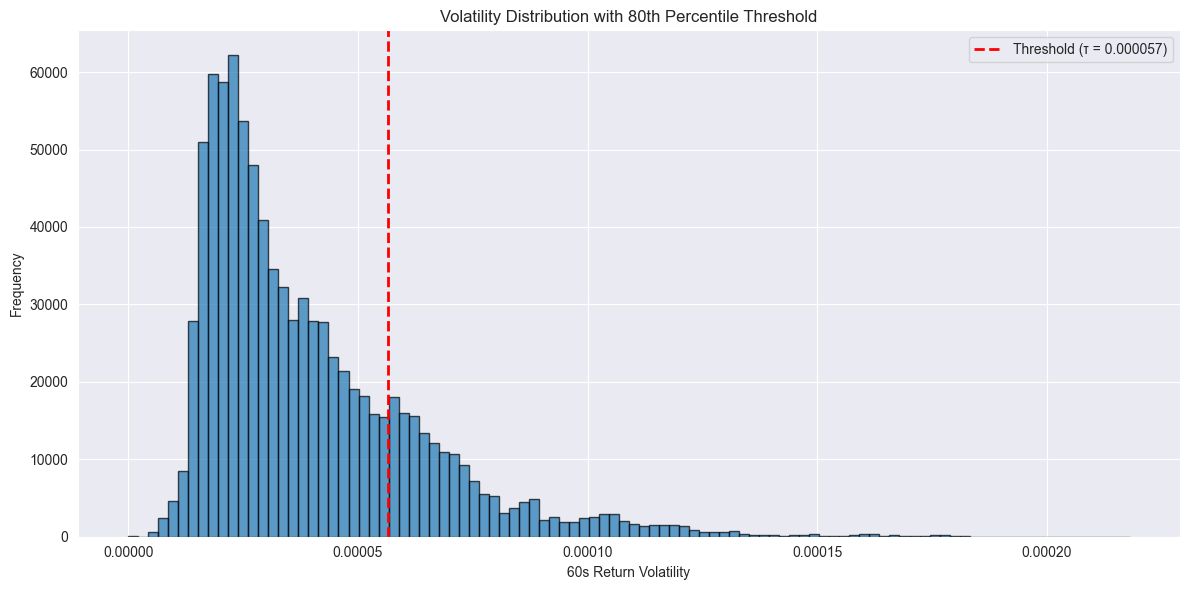

In [91]:
# Set chosen threshold.
CHOSEN_THRESHOLD_PERCENTILE = 80
THRESHOLD = tar_volatility.quantile(CHOSEN_THRESHOLD_PERCENTILE / 100)

print(f'### CHOSEN THRESHOLD ###')
print(f'Percentile: {CHOSEN_THRESHOLD_PERCENTILE}th')
print(f'Threshold value (τ): {THRESHOLD:.6f}')
print(f'Expected spike rate: {(100 - CHOSEN_THRESHOLD_PERCENTILE):.0f}%')

# Visualize on distribution.
plt.figure(figsize=(12, 6))
plt.hist(tar_volatility, bins=100, alpha=0.7, edgecolor='black')
plt.axvline(THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold (τ = {THRESHOLD:.6f})')
plt.xlabel('60s Return Volatility')
plt.ylabel('Frequency')
plt.title(f'Volatility Distribution with {CHOSEN_THRESHOLD_PERCENTILE}th Percentile Threshold')
plt.legend()
plt.tight_layout()
plt.show()

## Temporal Patterns

Examining how volatility varies over time.

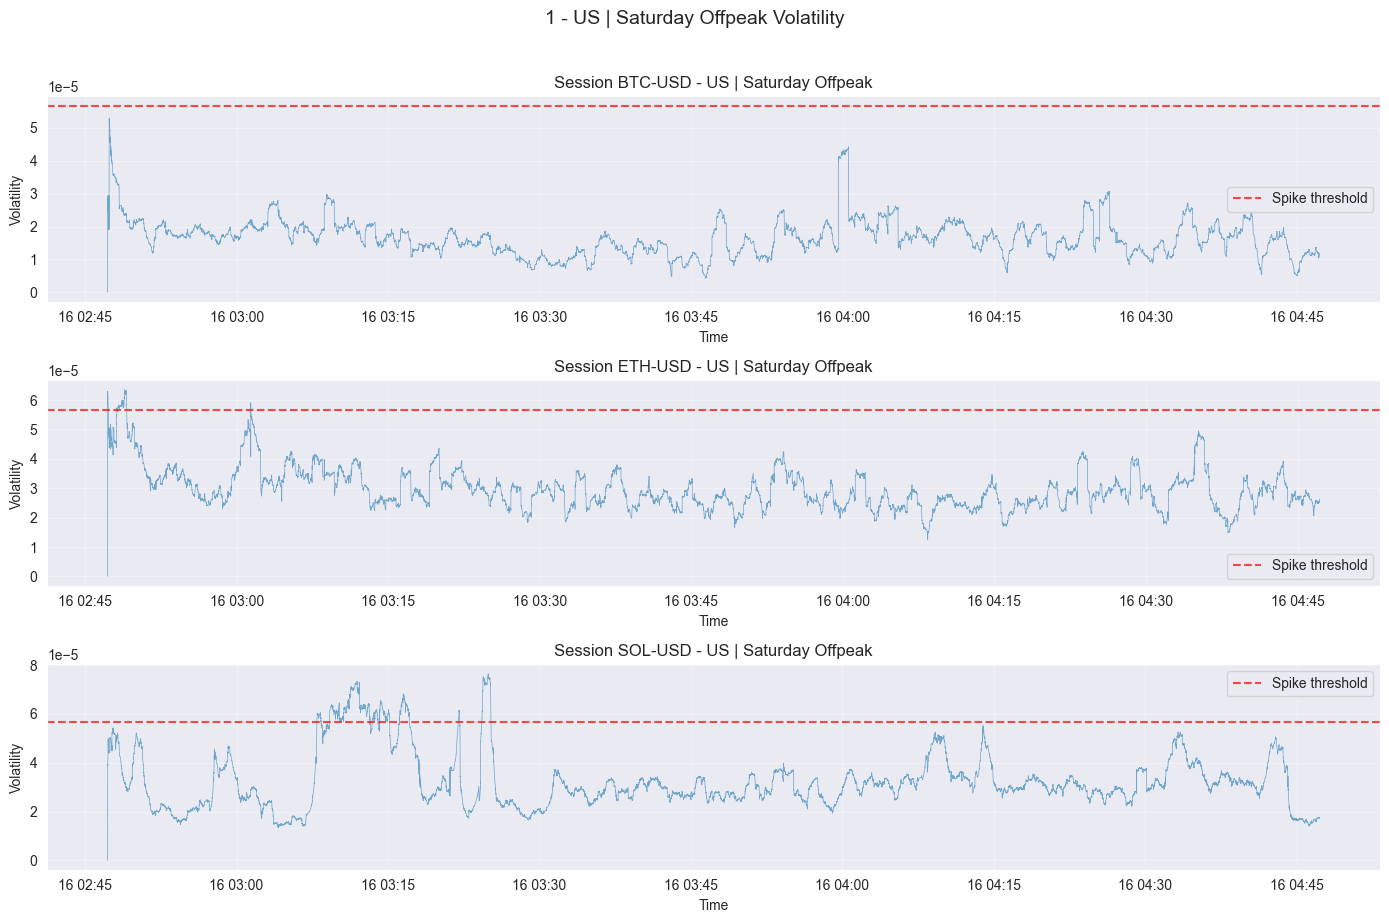

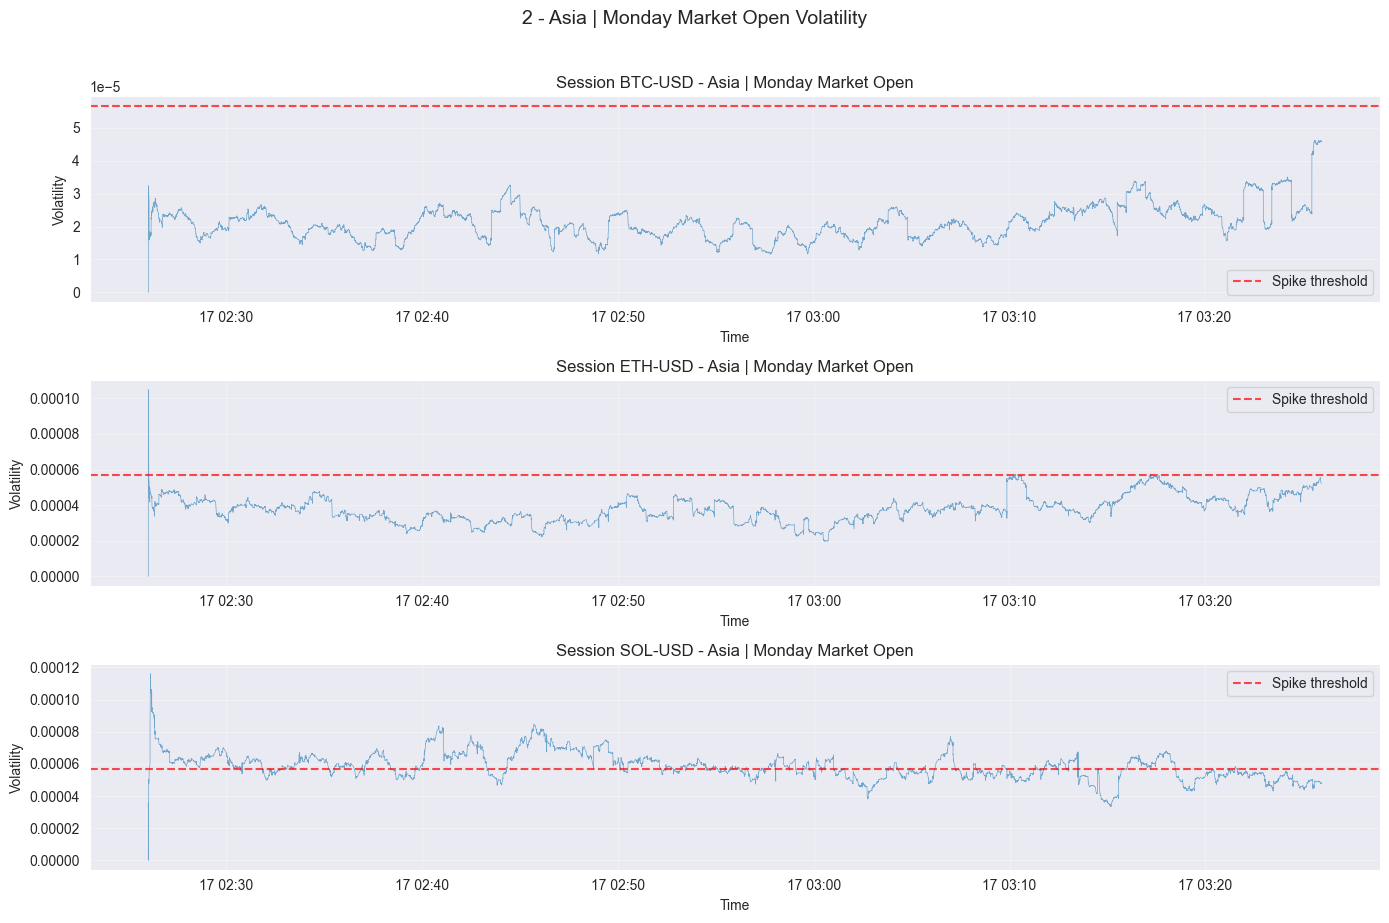

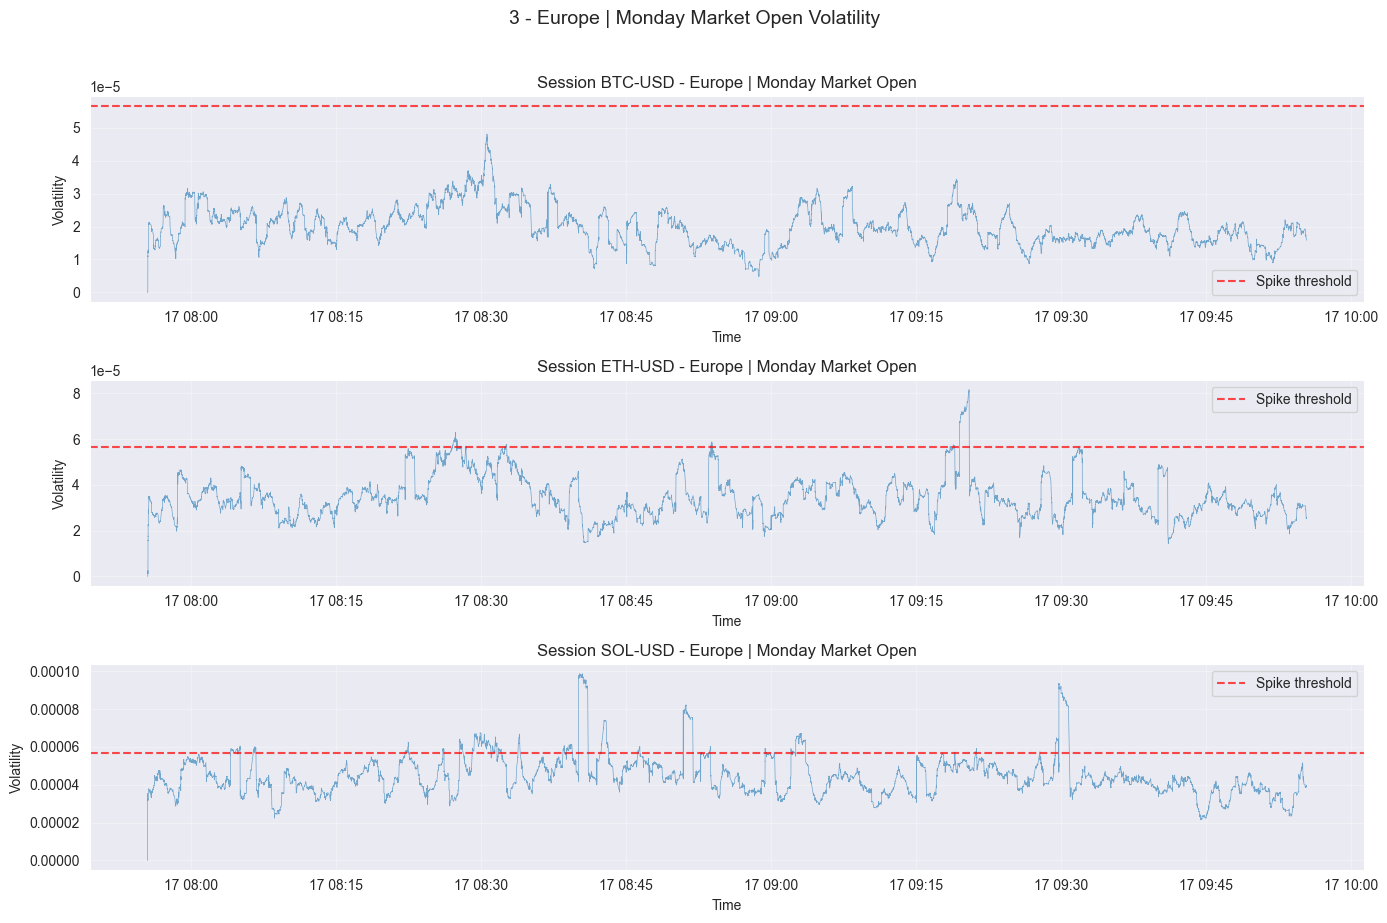

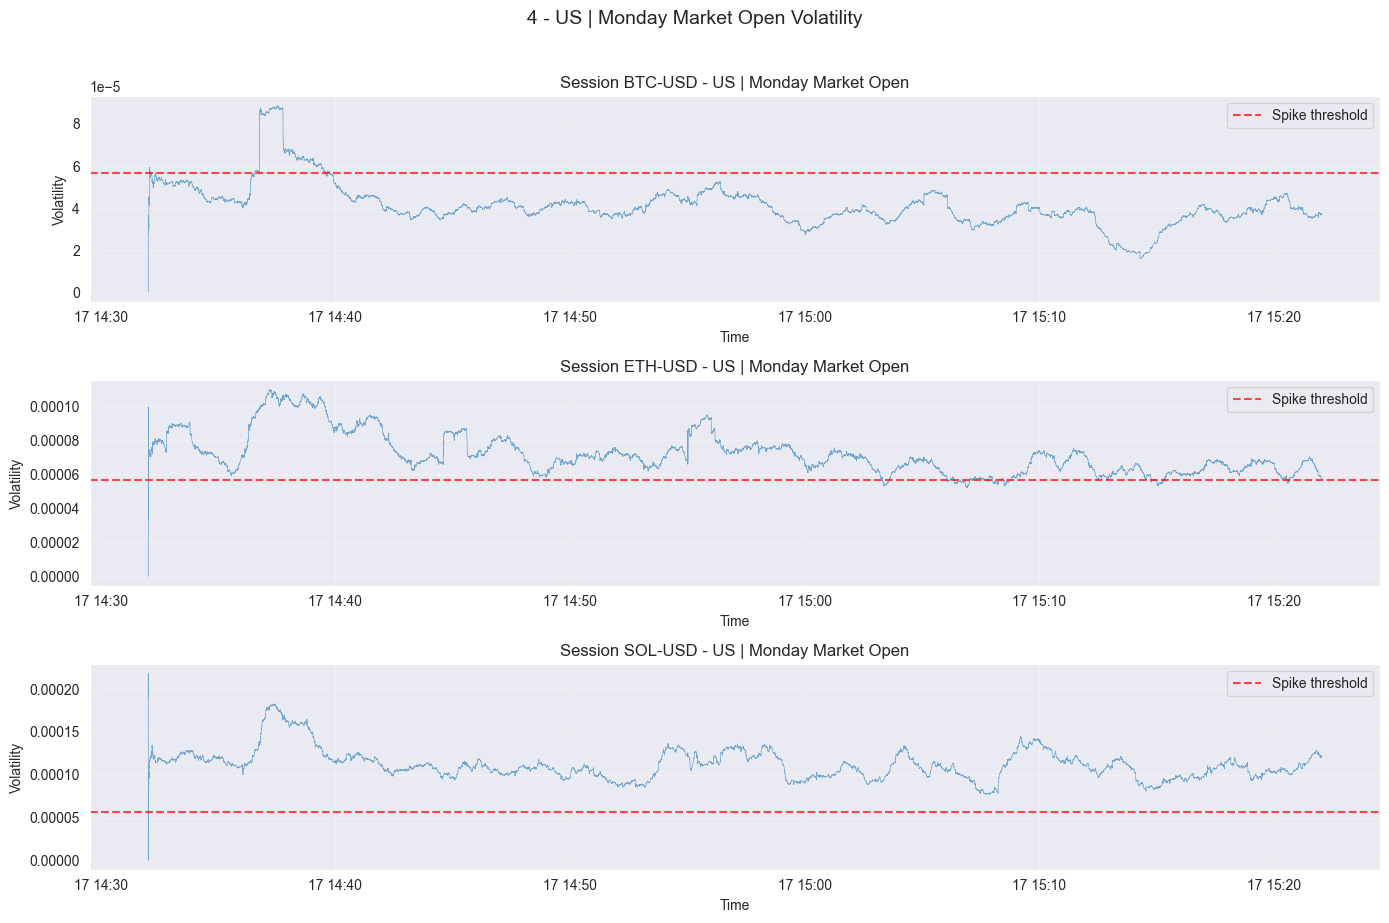

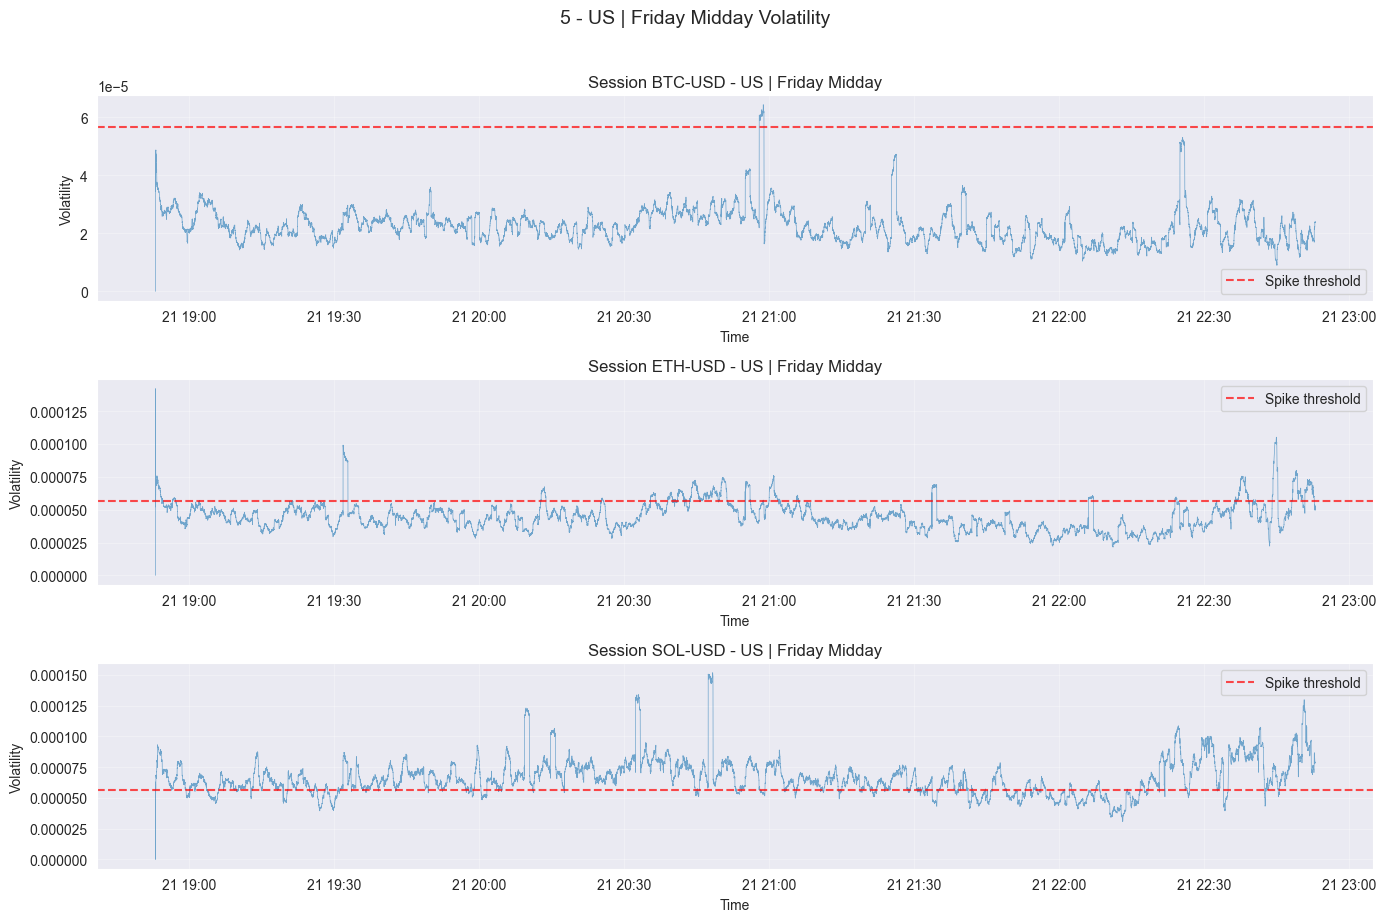

In [92]:
# Plot volatility for each session

for session in df_sorted['session'].unique():
    session_df = df_sorted[df_sorted['session'] == session]
    
    fig, axes = plt.subplots(len(target_products), 1, figsize=(14, 3 * len(target_products)))

    sessions = {1: 'US | Saturday Offpeak',
                2: 'Asia | Monday Market Open',
                3: 'Europe | Monday Market Open',
                4: 'US | Monday Market Open',
                5: 'US | Friday Midday'                
                }
    
    if len(target_products) == 1:
        axes = [axes]
    
    for idx, product in enumerate(target_products):
        product_df = session_df[session_df['product_id'] == product].sort_values('timestamp')
        
        if len(product_df) > 0 and 'w60_return_std' in product_df.columns:
            ax = axes[idx]
            ax.plot(product_df['timestamp'], product_df['w60_return_std'], alpha=0.6, linewidth=0.5)
            ax.axhline(THRESHOLD, color='red', linestyle='--', alpha=0.7, label='Spike threshold')
            ax.set_title(f'Session {product} - {sessions[session + 1]}') # Prevent Key Error.
            ax.set_xlabel('Time')
            ax.set_ylabel('Volatility')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{session + 1} - {sessions[session + 1]} Volatility', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

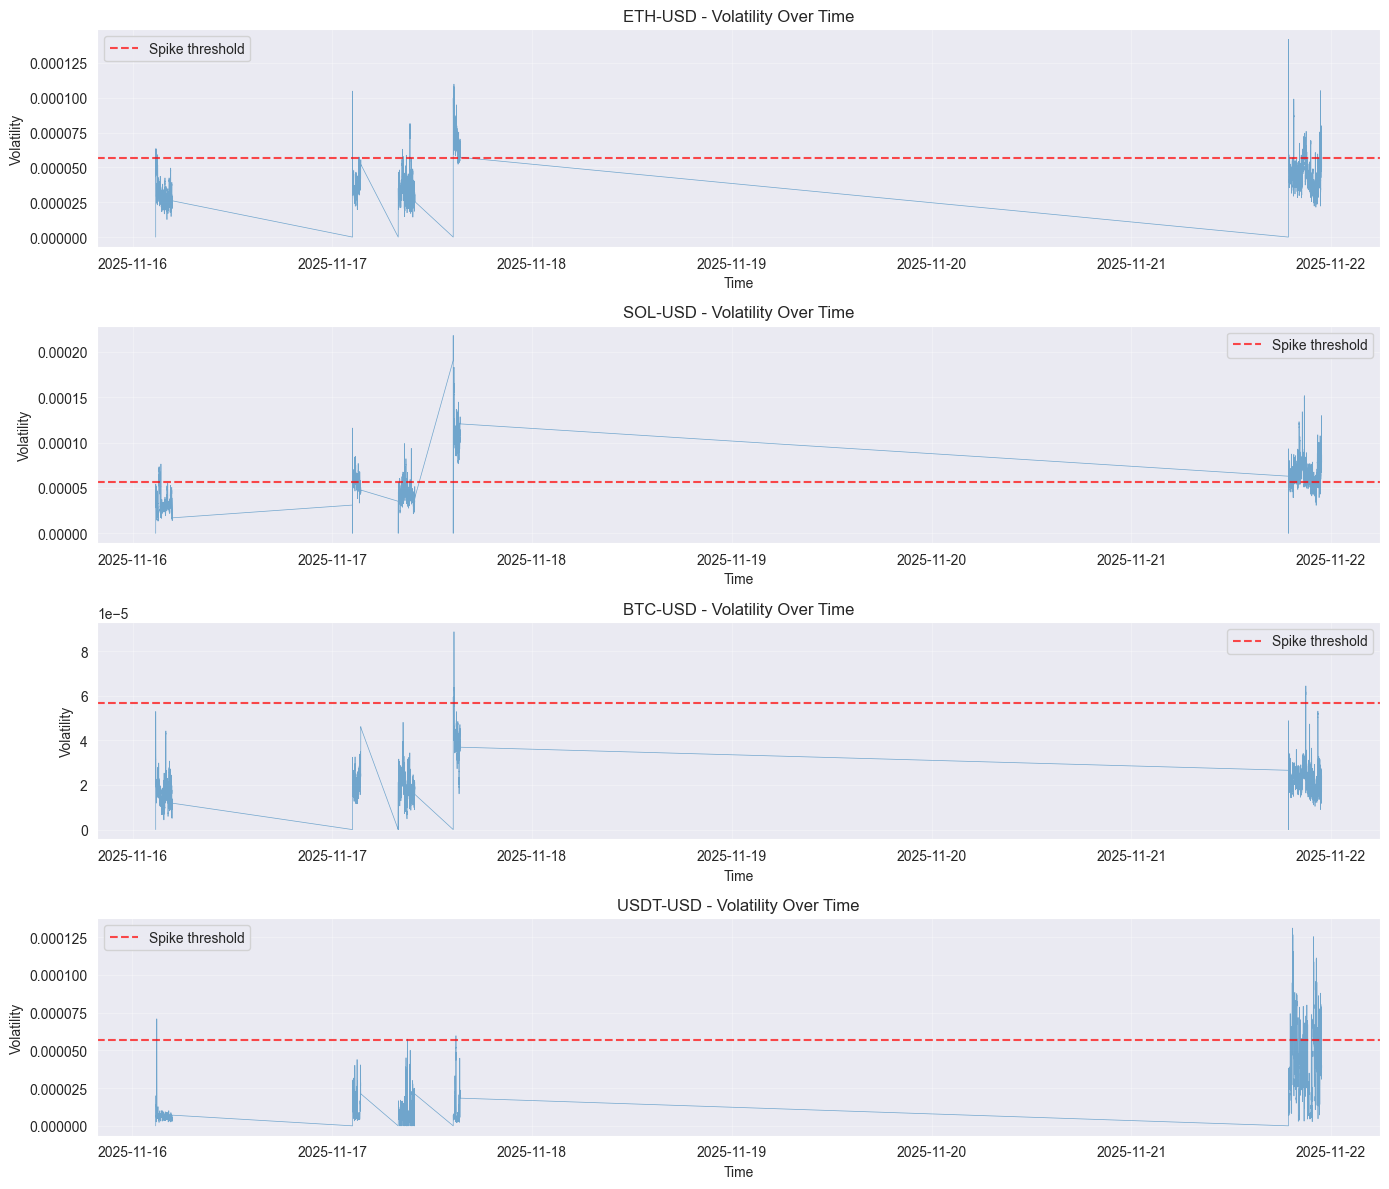

In [93]:
# Volatility time series by product.
# Keep in mind the flat lines are where there wasn't data.
fig, axes = plt.subplots(len(df['product_id'].unique()), 1, figsize=(14, 3 * len(df['product_id'].unique())))

if len(df['product_id'].unique()) == 1:
    axes = [axes]

for idx, product in enumerate(df['product_id'].unique()):
    product_df = df[df['product_id'] == product].sort_values('timestamp')
    
    if 'w60_return_std' in product_df.columns:
        ax = axes[idx]
        ax.plot(product_df['timestamp'], product_df['w60_return_std'], alpha=0.6, linewidth=0.5)
        ax.axhline(THRESHOLD, color='red', linestyle='--', alpha=0.7, label='Spike threshold')
        ax.set_title(f'{product} - Volatility Over Time')
        ax.set_xlabel('Time')
        ax.set_ylabel('Volatility')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Sequential Volatility

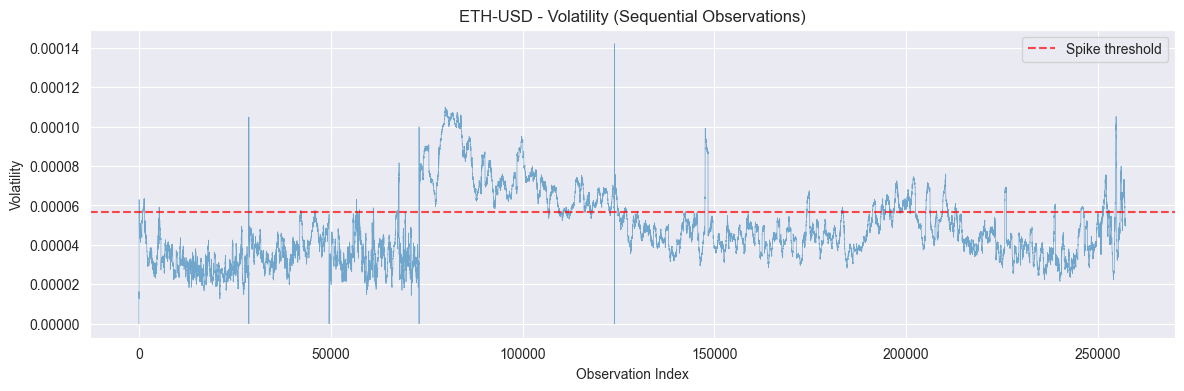

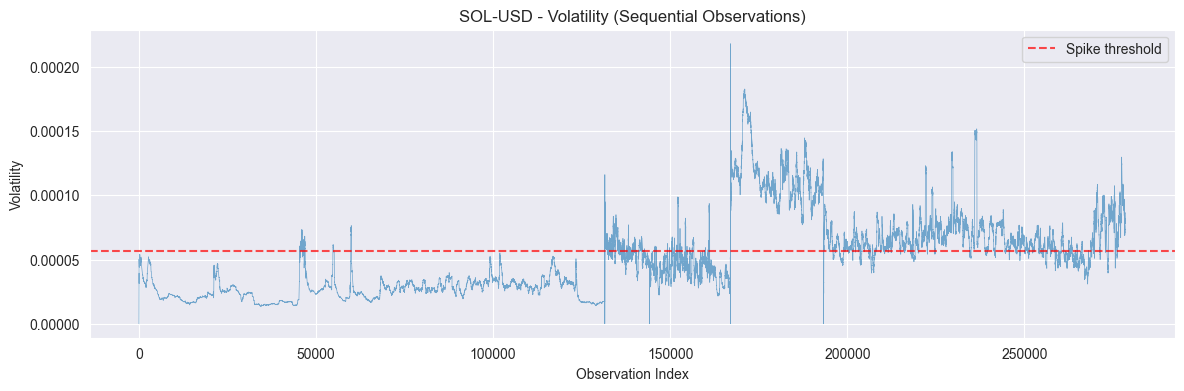

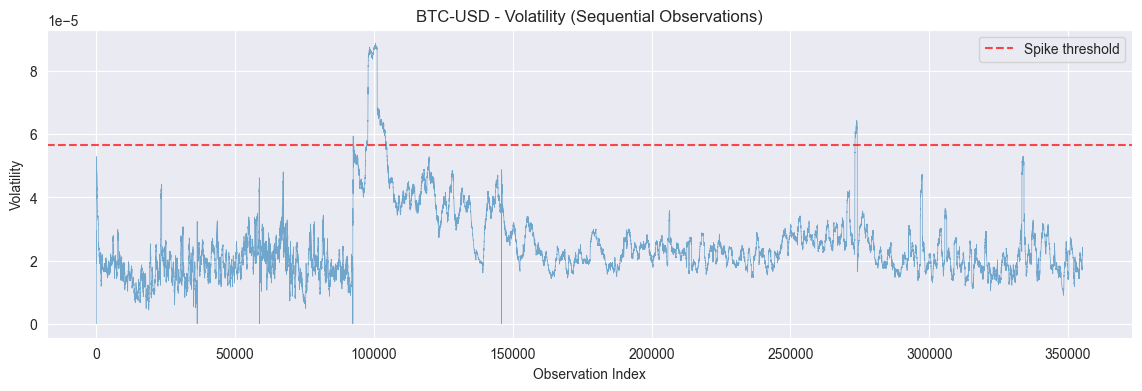

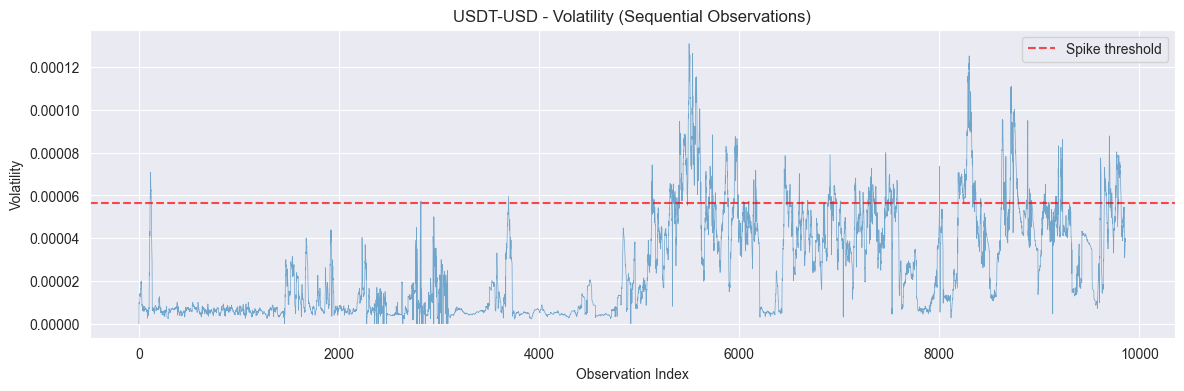

In [94]:
for product in df['product_id'].unique():
    product_df = df[df['product_id'] == product].sort_values('timestamp').reset_index(drop=True)
    
    plt.figure(figsize=(14, 4))
    plt.plot(product_df.index, product_df['w60_return_std'], alpha=0.6, linewidth=0.5)
    plt.axhline(THRESHOLD, color='red', linestyle='--', alpha=0.7, label='Spike threshold')
    plt.title(f'{product} - Volatility (Sequential Observations)')
    plt.xlabel('Observation Index')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

## Evidently Report

Run the Evidently report.

I have data from different market regimes and different products. My earliest data are from weekend offpeak hours, and my later data are from Monday market openings in different global markets. Using the former as the early set and the latter as the late set seems potentially ill-advised. I don't really know what is going to be useful yet, so I am going to look at drift from a few different angles.

In [95]:
from pathlib import Path

Path('reports/evidently').mkdir(parents=True, exist_ok=True)

# Get feature columns for drift analysis.
feature_cols = [col for col in df.columns if col.startswith('w')]
time_features = ['hour_sin', 'hour_cos', 'day_of_week']
feature_cols.extend([f for f in time_features if f in df.columns])
correlations = df[feature_cols].corrwith(df['target_spike']).abs().sort_values(ascending=False)

# Remove features with zero variance.
def get_variable_features(df, feature_cols):
    '''Filter to features with non-zero variance.'''

    variable_cols = []
    for col in feature_cols:
        if df[col].std() > 0 and df[col].notna().sum() > 0:
            variable_cols.append(col)
    return variable_cols

# Within-session drift - Measure feature stability during individual continuous data collection sessions.
print('WITHIN-SESSION DRIFT')
for session in df_sorted['session'].unique():
    session_df = df_sorted[df_sorted['session'] == session][feature_cols].copy()

    variable_features = get_variable_features(session_df, feature_cols)
    
    midpoint_idx = len(session_df) // 2
    early_df = session_df.iloc[:midpoint_idx][variable_features]
    late_df = session_df.iloc[midpoint_idx:][variable_features]
    
    report = Report(metrics=[DataDriftPreset()])
    result = report.run(late_df, early_df)
    result.save_html(f'reports/evidently/drift_within_session_{session}.html')
    result.save_json(f'reports/evidently/drift_within_session_{session}.json')
    print(f'Session {session}: {len(early_df):,} vs {len(late_df):,} observations')

# Cross-session drift - Measure across market regimes.
print('\nCROSS-SESSION DRIFT')
sessions = sorted(df_sorted['session'].unique())
print(sessions)

variable_features = get_variable_features(df_sorted, feature_cols)

first_session = df_sorted[df_sorted['session'] == sessions[0]][variable_features] # Index is still 0.
last_session = df_sorted[df_sorted['session'] == sessions[-1]][variable_features]

report = Report(metrics=[DataDriftPreset()])
result = report.run(late_df, early_df)
result.save_html(f'reports/evidently/drift_cross_session.html')
result.save_json(f'reports/evidently/drift_cross_Session.json')
print(f'Session {sessions[0]} vs Session {sessions[-1]}')

# Per-product drift
print('\nPER-PRODUCT DRIFT')
for product in target_products:
    product_df = df[df['product_id'] == product].sort_values('timestamp')[feature_cols].copy()

    variable_features = get_variable_features(product_df, feature_cols)
    
    midpoint_idx = len(product_df) // 2
    early_df = product_df.iloc[:midpoint_idx][variable_features]
    late_df = product_df.iloc[midpoint_idx:][variable_features]
    
    report = Report(metrics=[DataDriftPreset()])
    result = report.run(late_df, early_df)
    result.save_html(f'reports/evidently/drift_per_product_{product}.html')
    result.save_json(f'reports/evidently/drift_per_produc_{product}.json')
    print(f'{product}: {len(early_df):,} vs {len(late_df):,} observations')

# Overall drift - all sesisons
print('\nOVERALL DRIFT')
all_features = df.sort_values('timestamp')[feature_cols].copy()

variable_features = get_variable_features(all_features, feature_cols)

midpoint_idx = len(all_features) // 2
early_df = all_features.iloc[:midpoint_idx][variable_features]
late_df = all_features.iloc[midpoint_idx:][variable_features]

report = Report(metrics=[DataDriftPreset()])
result = report.run(late_df, early_df)
result.save_html(f'reports/evidently/drift_overall.html')
result.save_json(f'reports/evidently/drift_overall.json')
print(f'Overall: {len(early_df):,} vs {len(late_df):,} observations')

print('\nREPORTS SAVED')
print(f'Location: reports/evidently/')

WITHIN-SESSION DRIFT
Session 0: 98,959 vs 98,960 observations
Session 1: 28,414 vs 28,415 observations
Session 2: 40,379 vs 40,379 observations
Session 3: 66,263 vs 66,263 observations
Session 4: 216,376 vs 216,376 observations

CROSS-SESSION DRIFT
[0, 1, 2, 3, 4]
Session 0 vs Session 4

PER-PRODUCT DRIFT
BTC-USD: 177,656 vs 177,657 observations
ETH-USD: 128,566 vs 128,567 observations
SOL-USD: 139,238 vs 139,239 observations

OVERALL DRIFT
Overall: 450,392 vs 450,392 observations

REPORTS SAVED
Location: reports/evidently/


Cross-session does not drift for volatility features, which is a relief. This should simplify training data split. The detected drift within a number of the sessions is not surprising. It is consistent with market behavior, and it suggests maybe my model will be able to learn something useful. Knock me over with a feather - the overall drift report is really stable. I suppose at the different timescales this makes sense. I don't watch finance enough to know what to look for necessarily and suspect the wild activity in the Monday opening graphs spooked me more than was needed. This is hopefully another relief as far as simplification for model training.

Cross-Session Drift Analysis:
- Overall: Minimal drift detected in core predictive features
- Stable features: return_std, spread_mean, trade_imbalance
- Drifted features: trade_count (expected due to varying market activity)
- Conclusion: Model should generalize across market sessions; no significant concerns for deployment